# Imports

In [23]:
from collections import defaultdict

import hypertools as hyp
import numpy as np
import pandas as pd
from scipy.signal import resample
from scipy.spatial.distance import cdist

from khan_helpers import Experiment
from khan_helpers.constants import (
    BOS_LECTURE_COLOR,
    BOS_QUESTION_COLOR,
    FIG_DIR,
    FORCES_LECTURE_COLOR,
    FORCES_QUESTION_COLOR,
    GENERAL_QUESTION_COLOR,
    LECTURE_WSIZE,
    RAW_DIR, 
    TRAJS_DIR
)
from khan_helpers.functions import (
    _ts_to_sec,
    interp_lecture,
    parse_windows,
)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load LDA embeddings and raw data to create BERT embeddings

In [13]:
exp = Experiment()

forces_traj_lda = exp.forces_traj
bos_traj_lda = exp.bos_traj
questions_vecs_lda = exp.question_vectors

forces_transcript = exp.forces_transcript
bos_transcript = exp.bos_transcript
questions_text = exp.questions['question'].tolist()

# Parse lecture transcripts into overlapping sliding windows

In [3]:
# make the same minor corrections to the transcripts as for the LDA 
# version, but don't do any further preprocessing since GPT-J is 
# context-sensitive
transcription_tweaks = {
    'cork': 'quark',
    'sub atomic': 'subatomic',
    'sub nucleic': 'subnucleic',
    'electro magnetic': 'electromagnetic',
    'electro static': 'electrostatic',
    'Ullom': 'coulomb',
    'cool': 'coulomb',
    'Hugh': 'huge',
    'hydrogen too': 'hydrogen two',
    ' eat': ' heat',
    ' cure ': ' core ',
    '10 ': 'ten ',
    '38 ': 'thirtyeight ',
    '38th ': 'thirtyeight ',
    '36 ': 'thirtysix',
    '25 ': 'twentyfive',
    '25th ': 'twentyfive'
}

for old, new in transcription_tweaks.items():
    forces_transcript = forces_transcript.replace(old, new)
    bos_transcript = bos_transcript.replace(old, new)
    
forces_windows_unprocessed, forces_timestamps = parse_windows(forces_transcript, 
                                                              LECTURE_WSIZE)
bos_windows_unprocessed, bos_timestamps = parse_windows(bos_transcript, 
                                                        LECTURE_WSIZE)
# remove trailing timestamp
forces_timestamps = forces_timestamps[:-1]
bos_timestamps = bos_timestamps[:-1]

# Save lecture and question text to create BERT embeddings

Done in this Colab notebook: https://colab.research.google.com/drive/1S4KQSfQvqgR2Ft9asck9VAJLM48FTbfu

In [4]:
# np.save(RAW_DIR.joinpath('forces_windows_unprocessed'), forces_windows_unprocessed)
# np.save(RAW_DIR.joinpath('bos_windows_unprocessed'), bos_windows_unprocessed)

# Load in BERT embeddings

In [12]:
forces_traj_bert_windows = np.load(TRAJS_DIR.joinpath('forces_traj_BERT.npy'))
bos_traj_bert_windows = np.load(TRAJS_DIR.joinpath('bos_traj_BERT.npy'))
questions_vecs_bert = np.load(TRAJS_DIR.joinpath('all_questions_BERT.npy'))

In [9]:
# interpolate lecture trajectories to 1 topic vector per second
forces_traj_bert = interp_lecture(forces_traj_bert_windows, forces_timestamps)
bos_traj_bert = interp_lecture(bos_traj_bert_windows, bos_timestamps)

In [7]:
def plot_3d_trajectories(
    lec1, 
    lec2, 
    questions, 
    resample_len=None, 
    smoothing_len=None,
    ax=None,
    **kwargs
):
    if resample_len is None:
        lec1_resampled, lec2_resampled = lec1, lec2
    else:
        lec1_resampled = resample(lec1, resample_len, axis=0)
        lec2_resampled = resample(lec2, resample_len, axis=0)
    
    if smoothing_len is None:
        lec1_smoothed, lec2_smoothed = lec1_resampled, lec2_resampled
    else:
        lec1_smoothed = (pd.DataFrame(lec1_resampled)
                         .rolling(smoothing_len)
                         .mean()
                         .loc[smoothing_len:, :]
                         .to_numpy())
        lec2_smoothed = (pd.DataFrame(lec2_resampled)
                         .rolling(smoothing_len)
                         .mean()
                         .loc[smoothing_len:, :]
                         .to_numpy())
    lec1_qs = questions[:15]
    lec2_qs = questions[15:30]
    gen_qs = questions[30:]
        
    geo = hyp.plot([lec1_smoothed, lec2_smoothed, lec1_qs, lec2_qs, gen_qs], 
                   fmt=['-', '-', 'o', 'o', 'o'], 
                   color=[FORCES_LECTURE_COLOR, 
                          BOS_LECTURE_COLOR, 
                          FORCES_QUESTION_COLOR, 
                          BOS_QUESTION_COLOR, 
                          GENERAL_QUESTION_COLOR], 
                   reduce={'model': 'IncrementalPCA', 'params': {'whiten': True}}, 
                   ax=ax,
                   **kwargs)
    return geo

In [56]:
def plot_correlation_timeseries(lecture, questions, ax=None, **kwargs):    
    if ax is None:
        ax = plt.gca()
    
    color = kwargs.pop('c', kwargs.pop('color', None))
    qcorrs = 1 - cdist(lecture, questions, 'correlation')
    ax.plot(qcorrs, color=color, **kwargs)
    
    ax.set_xlim(0, len(lecture))
    ticks = list(range(0, len(lecture) + 1, 60))
    ax.set_xticks(ticks, (f'{t // 60}:00' for t in ticks))
    
    ax.grid(visible=False)
    
    return ax

In [103]:
def plot_variance_corrmat(
    lec1, 
    lec2, 
    questions, 
    ticklabels=None,
    labelsize='medium',
    ax=None, 
    **kwargs
):
    # set argument defaults
    if ax is None:
        ax = plt.gca()
        
    if ticklabels is None:
        ticklabels = [
            'Four\nFundamental\nForces\nlecture', 
            'Four\nFundamental\nForces\nquestions', 
            'Birth of\nStars\nlecture', 
            'Birth of\nStars\nquestions', 
            'General\nphysics\nknowledge\nquestions'
        ]
    kwargs.setdefault('xticklabels', ticklabels[:-1] + [''])
    kwargs.setdefault('yticklabels', [''] + ticklabels[1:])
    
    kwargs.setdefault('square', True)
    kwargs.setdefault('fmt', '')
    annot_kws = {
        'style': 'italic',    
        'fontweight': 'semibold',
        'linespacing': 1.5
    }
    if (user_annot_kws := kwargs.pop('annot_kws', None)) is not None:
        annot_kws.update(user_annot_kws)
    
    if labelsize is None:
        labelsize = 'medium'
    
    # compute feature variances & pairwise correlations
    feature_vars = [lec1.var(axis=0),                # Lecture 1
                    lec2.var(axis=0),                # Lecture 2
                    questions[:15].var(axis=0),      # Lecture 1 questions
                    questions[15:30].var(axis=0),    # Lecture 2 questions
                    questions[30:].var(axis=0)]      # General knowledge questions
    
    # pairwise correlations for coloring heatmap (lower triangle only)
    vars_corrmat = np.full((len(feature_vars), len(feature_vars)), np.nan)
    # formatted r- and p-values for annotating heatmap cells (triu only)
    annot_matrix = np.empty_like(vars_corrmat, dtype=str)
    for i, x_vars in enumerate(feature_vars):
        for j, y_vars in enumerate(feature_vars):
            if i == j:
                break
                
            r, p = pearsonr(x_vars, y_vars)
            vars_corrmat[i, j] = r
            annot_matrix[i, j] = format_stats(r, p, stat_name='r')
            
    sns.heatmap(feature_vars, 
                annot=annot_matrix, 
                annot_kws=annot_kws, 
                ax=ax, 
                **kwargs)
    
    ax.tick_params(axis='x', rotation=0, length=0, labelsize=labelsize)
    ax.tick_params(axis='y', rotation=0, length=0, labelsize=labelsize)
    ax.set_xticklabels(ax.get_xticklabels(), ha='center')
    ax.set_yticklabels(ax.get_yticklabels(), ha='center')
    
    return ax

In [ ]:
with sns.plotting_context('talk', font_scale=1.1):
    fig = plt.figure()

In [19]:
with sns.plotting_context('talk'):
    

<Figure size 432x288 with 0 Axes>

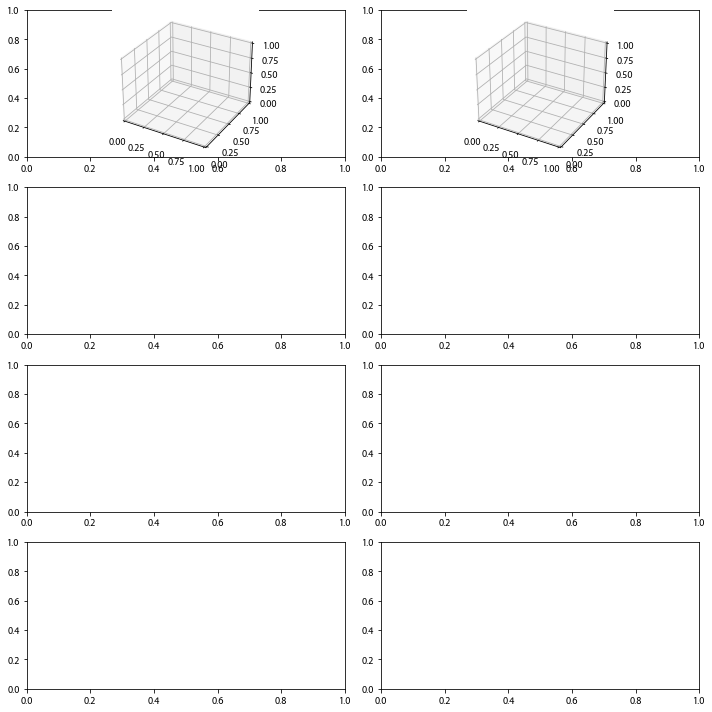

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure with 4 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(10, 10))

# Add the first 3D subplot in the top-left position
ax1 = fig.add_subplot(421, projection='3d')

# Add the second 3D subplot in the top-right position
ax2 = fig.add_subplot(422, projection='3d')

# You can access the 2D subplots using the axes array
ax3 = axes[1, 0]
ax4 = axes[1, 1]
ax5 = axes[2, 0]
ax6 = axes[2, 1]
ax7 = axes[3, 0]
ax8 = axes[3, 1]

# You can add your plotting code for each subplot here
# For the 3D subplots (ax1 and ax2), use 3D plotting functions

# Adjust the layout to prevent subplot overlap
plt.tight_layout()

# Show or save the figure
plt.show()


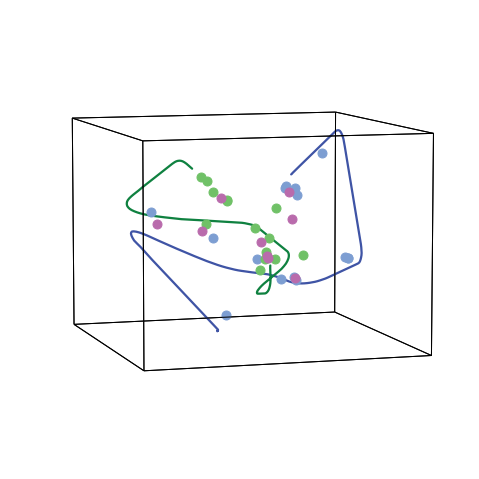

In [25]:
with sns.plotting_context('talk'):
    plot_3d_trajectories(forces_traj_lda, bos_traj_lda, questions_vecs_lda, resample_len=200, smoothing_len=24, 
                 azim=73, 
                 elev=7, size=[7, 7])

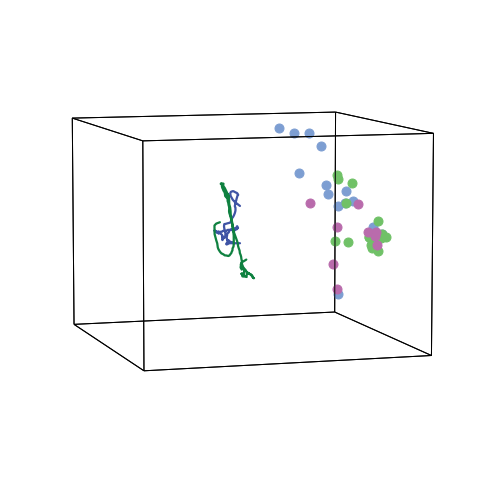

In [31]:
# resample trajectories to common length and smooth for visualization
bos_traj_bert_resampled = resample(bos_traj_bert, 200, axis=0)
forces_traj_bert_resampled = resample(forces_traj_bert, 200, axis=0)

forces_smoothed_bert = pd.DataFrame(forces_traj_bert_resampled).rolling(24).mean().loc[24:, :].to_numpy()
bos_smoothed_bert = pd.DataFrame(bos_traj_bert_resampled).rolling(24).mean().loc[24:, :].to_numpy()

forces_questions_bert = all_questions_bert[np.flatnonzero(exp.questions['lecture'] == 1)]
bos_questions_bert = all_questions_bert[np.flatnonzero(exp.questions['lecture'] == 2)]
general_questions_bert = all_questions_bert[np.flatnonzero(exp.questions['lecture'] == 0)]

with sns.plotting_context('talk'):
    hyp.plot([forces_smoothed_bert, 
              bos_smoothed_bert, 
              forces_questions_bert, 
              bos_questions_bert, 
              general_questions_bert], 
             fmt=['-', '-', 'o', 'o', 'o'],
             color=[FORCES_LECTURE_COLOR, 
                    BOS_LECTURE_COLOR, 
                    FORCES_QUESTION_COLOR, 
                    BOS_QUESTION_COLOR, 
                    GENERAL_QUESTION_COLOR],
             reduce={'model': 'IncrementalPCA', 'params': {'whiten': True}}, 
#              save_path=FIG_DIR.joinpath('trajectories-3d.pdf'),
             size=[7, 7], 
             azim=73, 
             elev=7)

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(1, projection='3d')

AttributeError: 'Figure' object has no property 'projection'

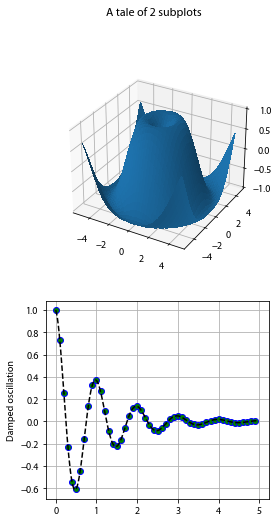

In [34]:
import matplotlib.pyplot as plt
import numpy as np


def f(t):
    return np.cos(2*np.pi*t) * np.exp(-t)


# Set up a figure twice as tall as it is wide
fig = plt.figure(figsize=plt.figaspect(2.))
fig.suptitle('A tale of 2 subplots')

# First subplot
ax = fig.add_subplot(2, 1, 2)

t1 = np.arange(0.0, 5.0, 0.1)
t2 = np.arange(0.0, 5.0, 0.02)
t3 = np.arange(0.0, 2.0, 0.01)

ax.plot(t1, f(t1), 'bo',
        t2, f(t2), 'k--', markerfacecolor='green')
ax.grid(True)
ax.set_ylabel('Damped oscillation')

# Second subplot
ax = fig.add_subplot(2, 1, 1, projection='3d')

X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                       linewidth=0, antialiased=False)
ax.set_zlim(-1, 1)

plt.show()